# 0.0. PREPARATION

## 0.1. Imports

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns



import matplotlib.pyplot as plt

from scipy                 import stats
from xgboost import XGBClassifier
from IPython.core.display  import HTML

from sklearn    import metrics         as mt
from sklearn import model_selection as ms

## 0.2. Load Data

In [8]:
df_raw = pd.read_csv('../data/abandono_clientes.csv')

### 0.2.1. Split Test Data

In [9]:
df1, df_test = ms.train_test_split(df_raw, test_size=0.1)

## 0.3. Helper Functions

In [60]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def corr_cramer_v(cat_attributes):
    cat_attributes_list = cat_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [20]:
jupyter_settings()

# 1.0. DATA DESCRIPTION

In [22]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1472,1473,15729956,Akabueze,726,Spain,Female,26,1,80780.16,1,1,1,19225.85,0
3263,3264,15807525,Bailey,447,France,Male,43,2,0.00,2,1,0,33879.26,1
5344,5345,15566269,Chialuka,787,France,Male,25,5,0.00,2,1,0,47307.90,0
711,712,15650288,Summers,634,Germany,Male,35,6,116269.01,1,1,0,129964.94,0
8866,8867,15810995,Wright,526,Germany,Male,34,3,122726.56,1,1,1,46772.36,0


## 1.1. Data Dimensions

In [23]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 9000
Number of columns: 14


## 1.2. Data Types

In [24]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3. Checks

In [26]:
# check na
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [30]:
# check duplicates
df1.duplicated().sum()

0

In [32]:
# check balance
df1['Exited'].value_counts(normalize=True)

Exited
0    0.796222
1    0.203778
Name: proportion, dtype: float64

## 1.4. Descriptive Analysis

In [50]:
num_attributes = df1.select_dtypes(include = ['int', 'float'])
cat_attributes = df1.select_dtypes(exclude = ['int', 'float'])

### 1.4.1. Numerical Attributes

In [51]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat metrics
num_statics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_statics.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [52]:
num_statics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,RowNumber,1.00,10000.00,9999.00,5.002269e+03,5.020500e+03,2885.789647,-0.005085,-1.200062
1,CustomerId,15565701.00,15815690.00,249989.00,1.569075e+07,1.569086e+07,72020.805262,0.001038,-1.194150
2,CreditScore,350.00,850.00,500.00,6.498718e+02,6.510000e+02,96.505081,-0.071024,-0.419509
3,Age,18.00,92.00,74.00,3.896011e+01,3.700000e+01,10.478861,1.009378,1.409707
4,Tenure,0.00,10.00,10.00,4.997444e+00,5.000000e+00,2.895033,0.014415,-1.167868
5,Balance,0.00,250898.09,250898.09,7.647002e+04,9.705515e+04,62405.035748,-0.141264,-1.491386
6,NumOfProducts,1.00,4.00,3.00,1.530444e+00,1.000000e+00,0.580197,0.738283,0.583440
7,HasCrCard,0.00,1.00,1.00,7.054444e-01,1.000000e+00,0.455843,-0.901533,-1.187502
8,IsActiveMember,0.00,1.00,1.00,5.190000e-01,1.000000e+00,0.499639,-0.076068,-1.994657
9,EstimatedSalary,11.58,199970.74,199959.16,1.001287e+05,1.004161e+05,57612.925203,0.000152,-1.186610


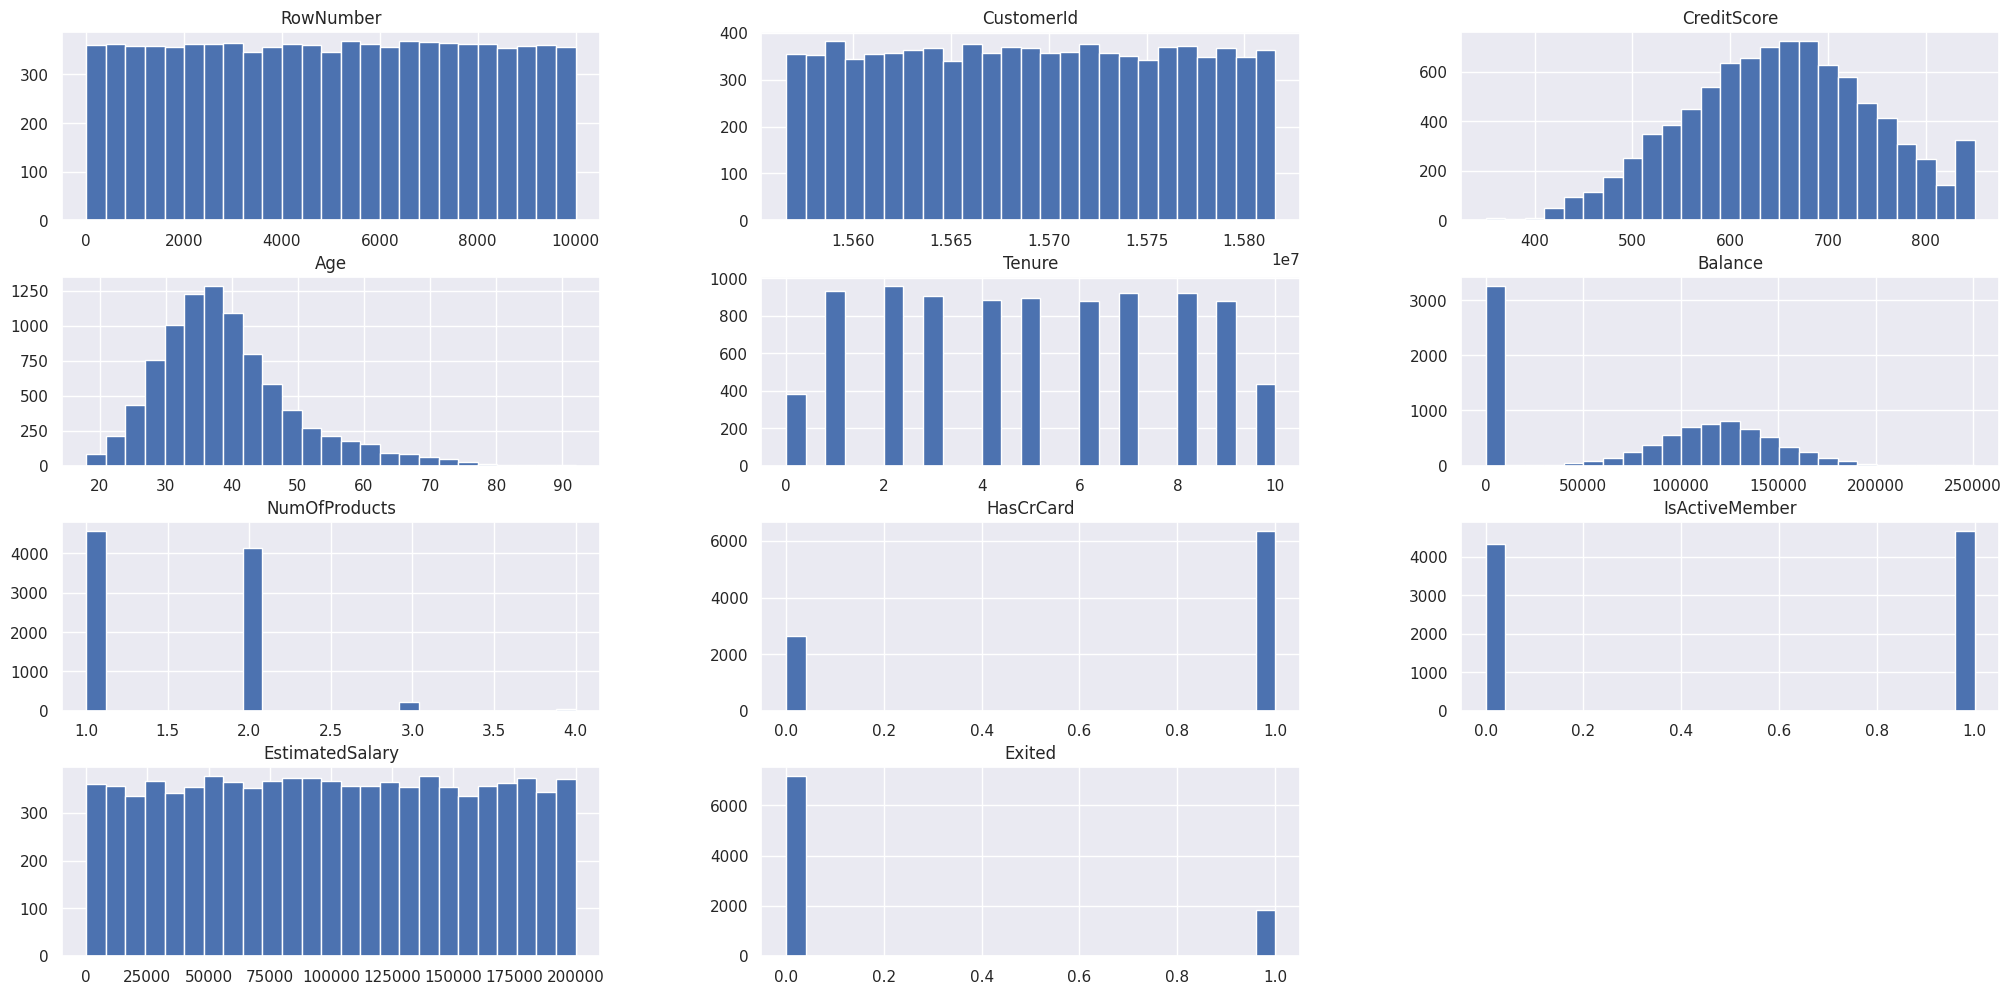

In [55]:
num_attributes.hist(bins=25);

### 1.4.2. Categorical Attributes

In [53]:
cat_attributes.apply(lambda x: x.unique().shape[0])

Surname      2764
Geography       3
Gender          2
dtype: int64

# 2.0. FEATURE ENGINEERING

In [57]:
df2 = df1.copy()

# 3.0. DATA FILTERING

In [58]:
df3 = df2.copy()

# 4.0. EXPLORATORY DATA ANALYSIS

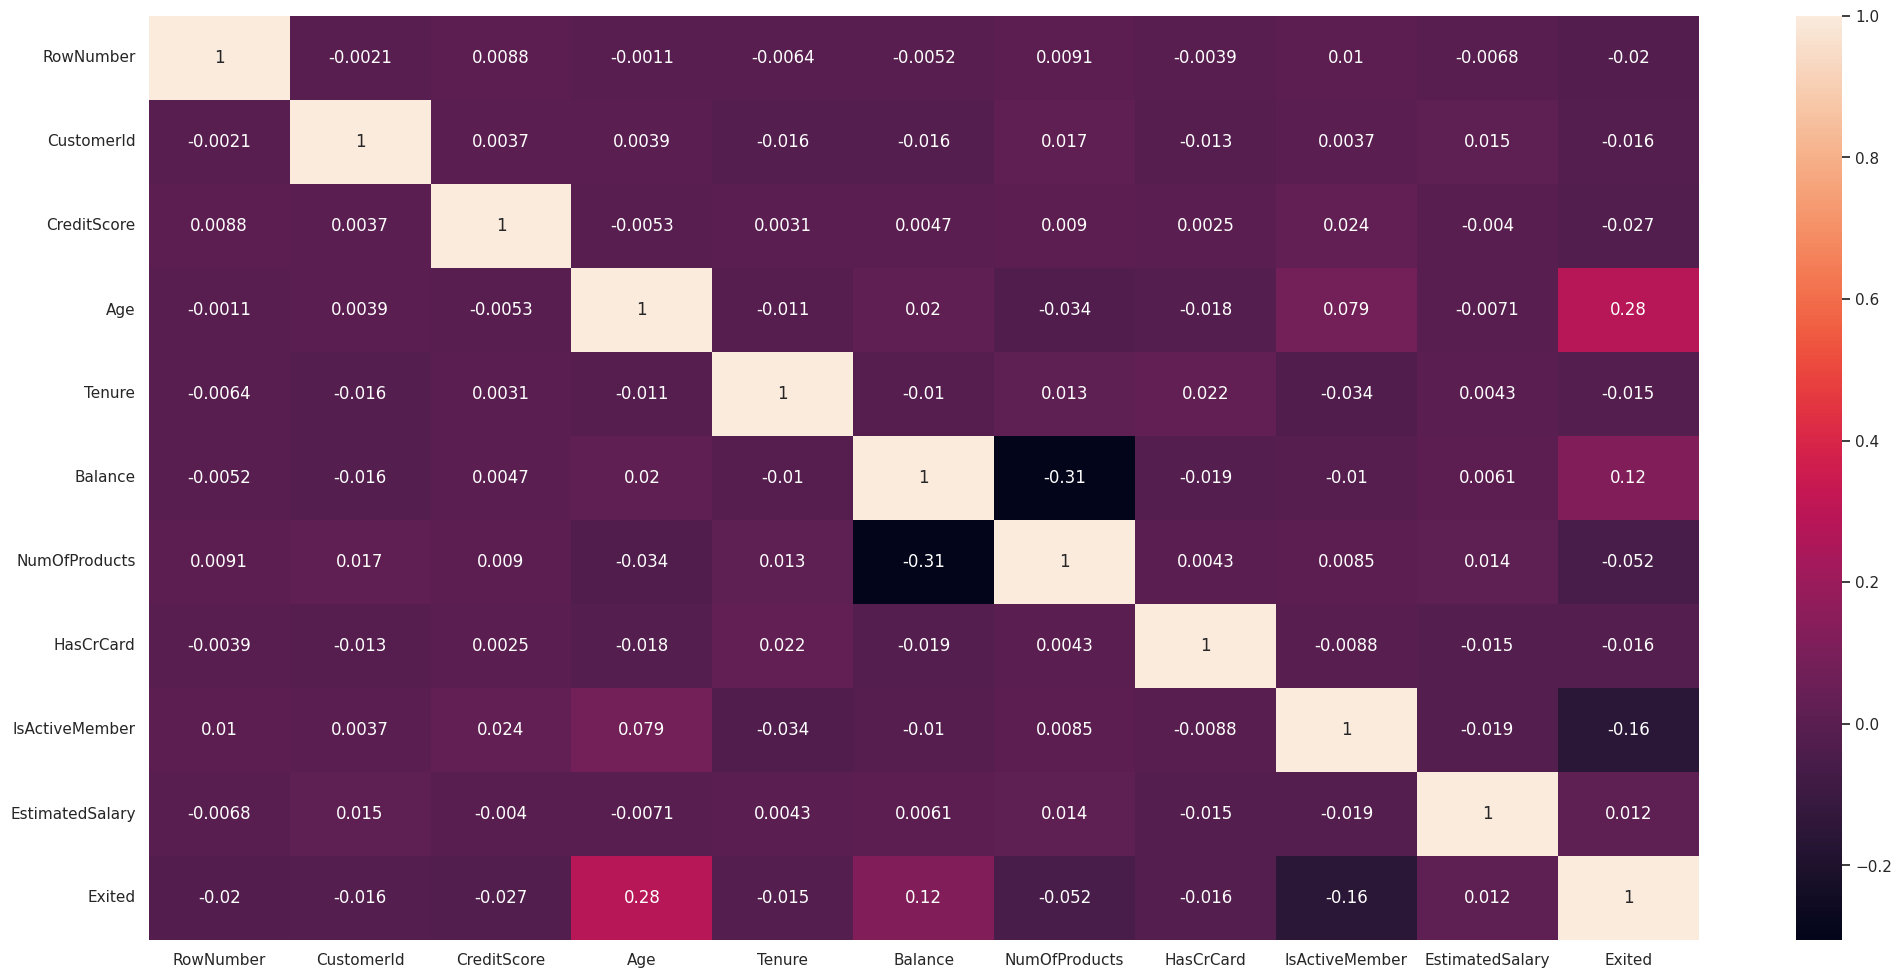

In [59]:
# using raw data (before feature engineering and data filtering)
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

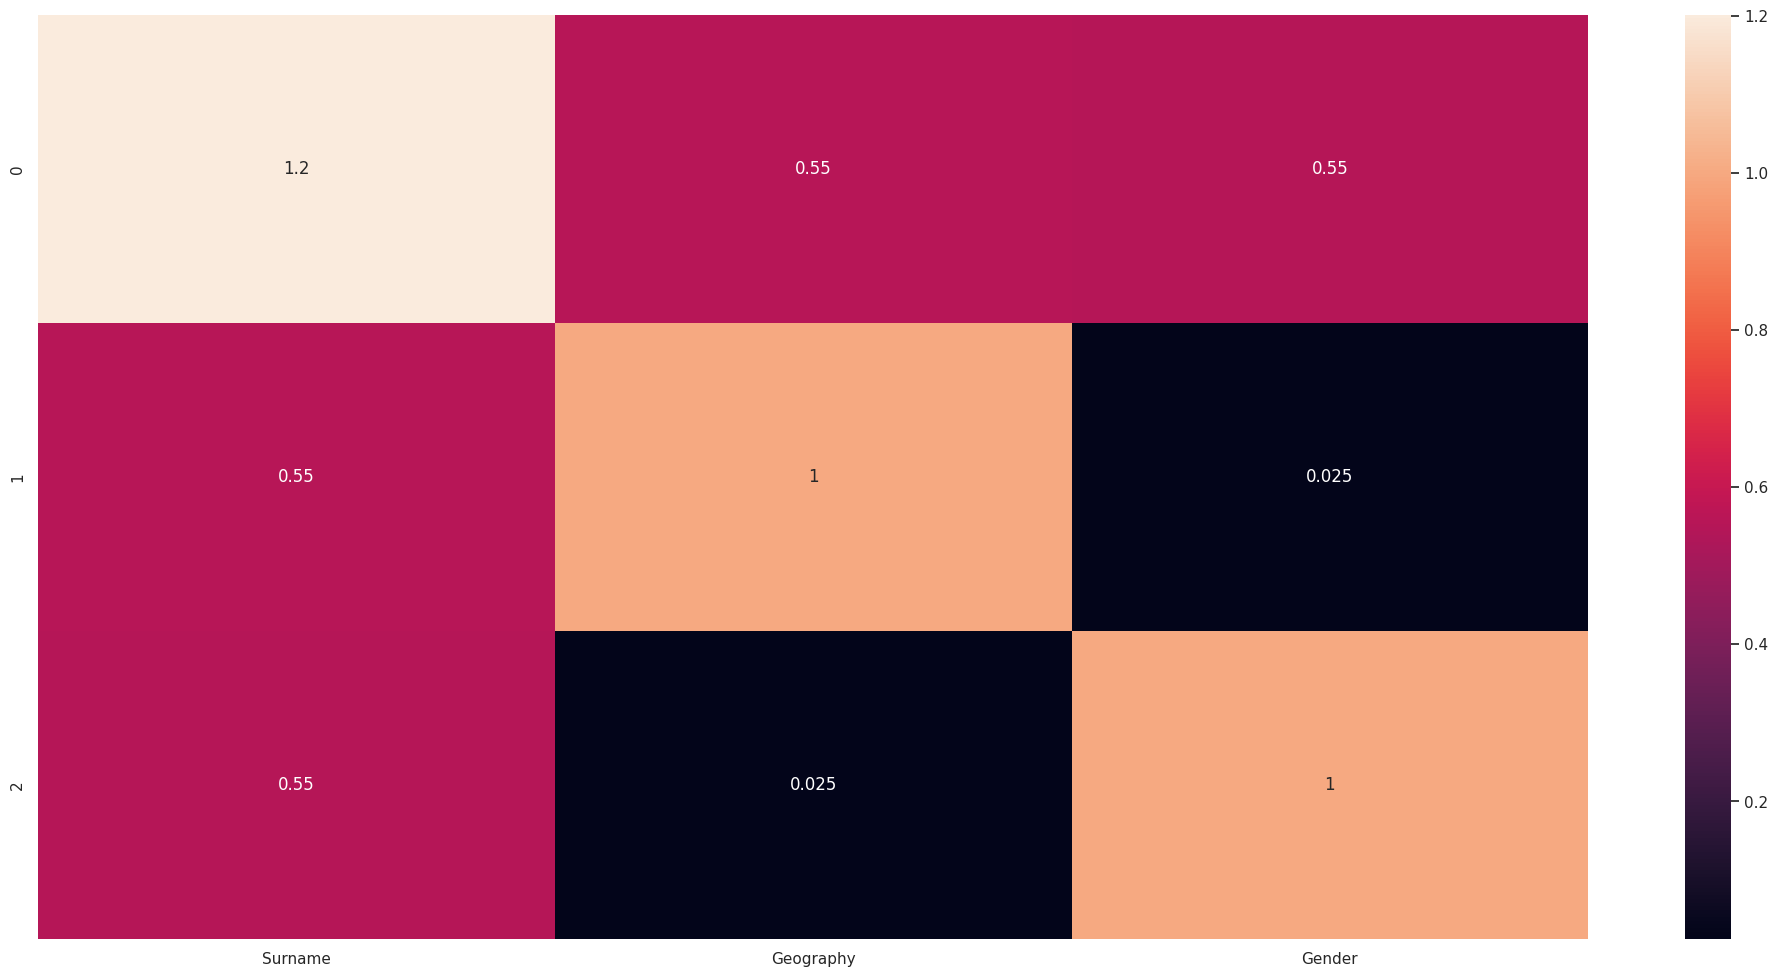

In [63]:
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

# 5.0. DATA PREPARATION

In [65]:
df5 = df3.copy()

In [66]:
df5.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1472,1473,15729956,Akabueze,726,Spain,Female,26,1,80780.16,1,1,1,19225.85,0
3263,3264,15807525,Bailey,447,France,Male,43,2,0.00,2,1,0,33879.26,1
5344,5345,15566269,Chialuka,787,France,Male,25,5,0.00,2,1,0,47307.90,0
711,712,15650288,Summers,634,Germany,Male,35,6,116269.01,1,1,0,129964.94,0
8866,8867,15810995,Wright,526,Germany,Male,34,3,122726.56,1,1,1,46772.36,0


In [69]:
# split training and validation datasets
X = df5.drop(['RowNumber', 'Exited'], axis=1)
y = df5['Exited'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

# 6.0. FEATURE SELECTION

# 7.0. MACHINE LEARNING MODELING

In [80]:
x_train = x_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]
x_val = x_validation[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]

In [81]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit(x_train,y_train.values.ravel())

# model prediction
yhat_xgb = xgb_model.predict(x_val)

# 8.0. HYPERPARAMETER FINE TUNING

# 9.0. MODEL PERFORMANCE

In [84]:
# calculate metrics
precision = mt.precision_score(y_validation, yhat_xgb)
recall = mt.recall_score(y_validation, yhat_xgb)
f1_score = mt.f1_score(y_validation, yhat_xgb, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.64257
Recall: 0.48338
F1 Score: 0.73282
